In [34]:
import cv2 
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from skimage.filters import threshold_otsu
import seaborn as sns
from skimage.color import rgb2gray
from skimage.morphology import convex_hull_image
from scipy.spatial import ConvexHull

In [11]:
path=r"C:\Users\Roumo\Desktop\WaterLevel\data_1\0.jpg"

In [4]:
def image_to_2d_array(image_path):
    # Read the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    mat = image
    return mat

In [32]:
def draw_line(r1, c1, r2, c2):
    """
    Generate pixel coordinates for a straight line between two points.
    """
    from skimage.draw import line
    return line(int(r1), int(c1), int(r2), int(c2))

43
0.18547928967614957


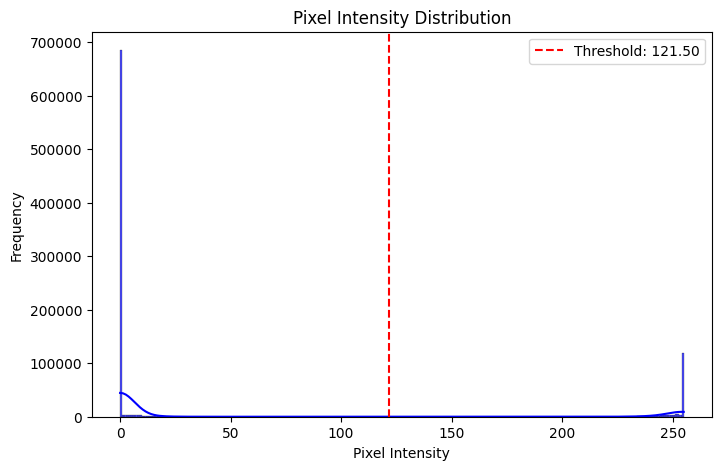

np.float64(0.18547928967614957)

In [29]:
def Feature_1(image_path):
    # Load the image and convert to grayscale
    image = Image.open(image_path).convert("L")
    image_array = np.array(image)
    
    # Calculate threshold using Otsu's method
    dynamic_threshold = threshold_otsu(image_array)
    print(dynamic_threshold)
    
    # Cap the threshold at a minimum of 200
    threshold = np.mean([dynamic_threshold, 200])

    # Compute the histogram of pixel intensities
    unique, counts = np.unique(image_array, return_counts=True)
    intensity_counts = dict(zip(unique, counts))

    # Identify values where the frequency is greater than 1
    valid_values = {val for val, freq in intensity_counts.items() if freq > 1}

    # Count pixels that are both above the threshold and meet the frequency condition
    high_intensity_count = np.sum([pixel in valid_values and pixel >= threshold for pixel in image_array.flatten()])
    
    # Normalize the count
    normalized_count = high_intensity_count / image_array.size
    print(normalized_count)
    
    # Plot histogram
    plt.figure(figsize=(8, 5))
    sns.histplot(image_array.flatten(), bins=256, kde=True, color='blue', alpha=0.7)
    plt.axvline(threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.title('Pixel Intensity Distribution')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()
    
    return normalized_count
Feature_1(path)

In [9]:
#Frobius Norm on entire Image

def Feature_2(image_path):
    # Load the image and convert it to grayscale
    image = Image.open(image_path).convert("L")
    
    # Convert the image to a numpy array
    image_array = np.array(image)
    
    # Compute the Frobenius norm
    frobenius_norm_value = np.linalg.norm(image_array, 'fro')
    
    return float(f"{frobenius_norm_value:.4f}")

Feature_2(path)

102974.226

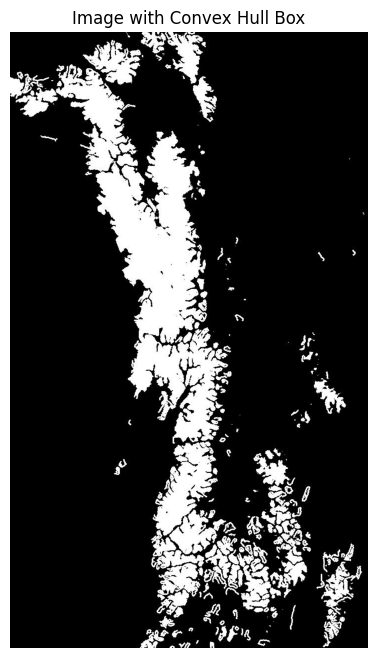

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(1242, 720, 3), dtype=uint8)

In [37]:
#Frobius on Glacier part
def Feature_3(image_path):
    """
    Applies convex hull processing to the input image and overlays a 4-cornered green box
    around the convex hull, ensuring it covers the major portion of the image.
    
    Parameters:
        image_path (str): Path to the image file.
        
    Returns:
        np.ndarray: Original image with the convex hull box overlaid.
    """
    # Load the image
    image = np.array(Image.open(image_path))
    if image.ndim == 3:  # If it's an RGB image
        gray_image = rgb2gray(image)  # Convert to grayscale
    else:
        gray_image = image  # If already grayscale
    
    # Binarize the image using Otsu's threshold
    threshold = threshold_otsu(gray_image)
    binary_image = gray_image >= threshold  # Convert to binary (foreground/background)
    
    # Get the coordinates of all foreground (white) pixels
    foreground_coords = np.column_stack(np.where(binary_image))
    
    # Compute the convex hull of the foreground pixels
    if len(foreground_coords) < 3:  # Edge case: if no foreground, return original image
        return image
    
    hull = ConvexHull(foreground_coords)
    
    # Get the vertices of the convex hull
    hull_points = foreground_coords[hull.vertices]
    
    # Create a bounding box (4-cornered box) around the convex hull
    min_row, min_col = hull_points.min(axis=0)
    max_row, max_col = hull_points.max(axis=0)
    box_corners = np.array([[min_row, min_col],
                            [min_row, max_col],
                            [max_row, max_col],
                            [max_row, min_col]])
    
    # Overlay the green box on the original image
    overlay_image = image.copy()
    if image.ndim == 2:  # Convert grayscale to RGB for visualization
        overlay_image = np.stack([overlay_image] * 3, axis=-1)
    
   
    
    # Plot the result
    plt.figure(figsize=(8, 8))
    plt.imshow(overlay_image)
    plt.title('Image with Convex Hull Box')
    plt.axis('off')
    plt.show()
    
    return overlay_image

Feature_3(path)